## Data Prep

In [277]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [278]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
import warnings
from sklearn.metrics import mean_squared_error

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [306]:
# follow same data prep procedures from ARIMA
data = pd.read_excel("owid-covid-data.xlsx")
italy_data = data[data['location'] == "Italy"]
italy_data = italy_data[['date', 'new_cases']]
#rename for prophet
italy_data.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
#drop missing values
italy_data['ds'] = pd.to_datetime(italy_data['ds'])
dates_to_drop = ['2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20']
italy_data = italy_data[~italy_data['ds'].isin(pd.to_datetime(dates_to_drop))]


In [307]:
italy_data.describe()

,ds,y
count,1351,1351.000000
mean,2021-11-08 00:00:00,19250.769060
min,2020-01-03 00:00:00,0.000000
25%,2020-12-05 12:00:00,1578.500000
50%,2021-11-08 00:00:00,6153.000000
75%,2022-10-11 12:00:00,23204.500000
max,2023-09-14 00:00:00,228123.000000
std,NaN,31559.033226


In [308]:
# test train split 
train=italy_data.iloc[:-14 ]
test=italy_data.iloc[-14: ]
print(train.shape, test.shape)

(1337, 2) (14, 2)


15:52:21 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing


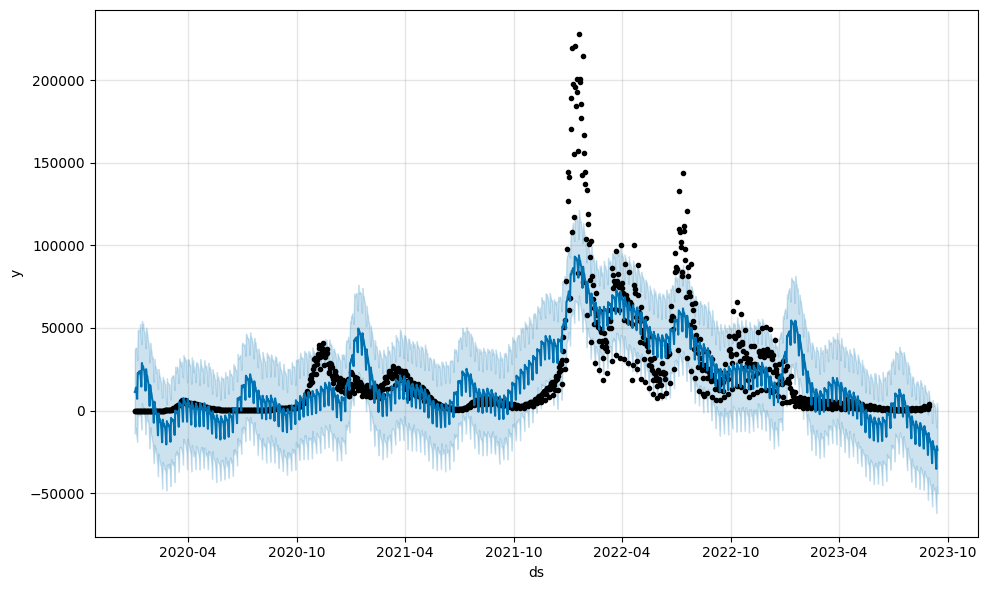

In [309]:
#dealing with outliers 
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=14)
forecast = m.predict(future)
fig = m.plot(forecast)

The effect of the extreme outliers in 2021 reverberated into the future.I will set the outliers as NA since Prophet can handle missing values.

In [310]:
#set outliers to NA
Q1 = train['y'].quantile(0.25)
Q3 = train['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train[(train['y'] < lower_bound) | (train['y'] > upper_bound)]

train.loc[train['y'] < lower_bound, 'y'] = None
train.loc[train['y'] > upper_bound, 'y'] = None

print(lower_bound)
print(upper_bound)

-31327.5
56292.5


In [324]:
train['cap'] = 40000
test['cap'] = 40000

## Model Development
### Model 1

15:53:55 - cmdstanpy - INFO - Chain [1] start processing
15:53:55 - cmdstanpy - INFO - Chain [1] done processing


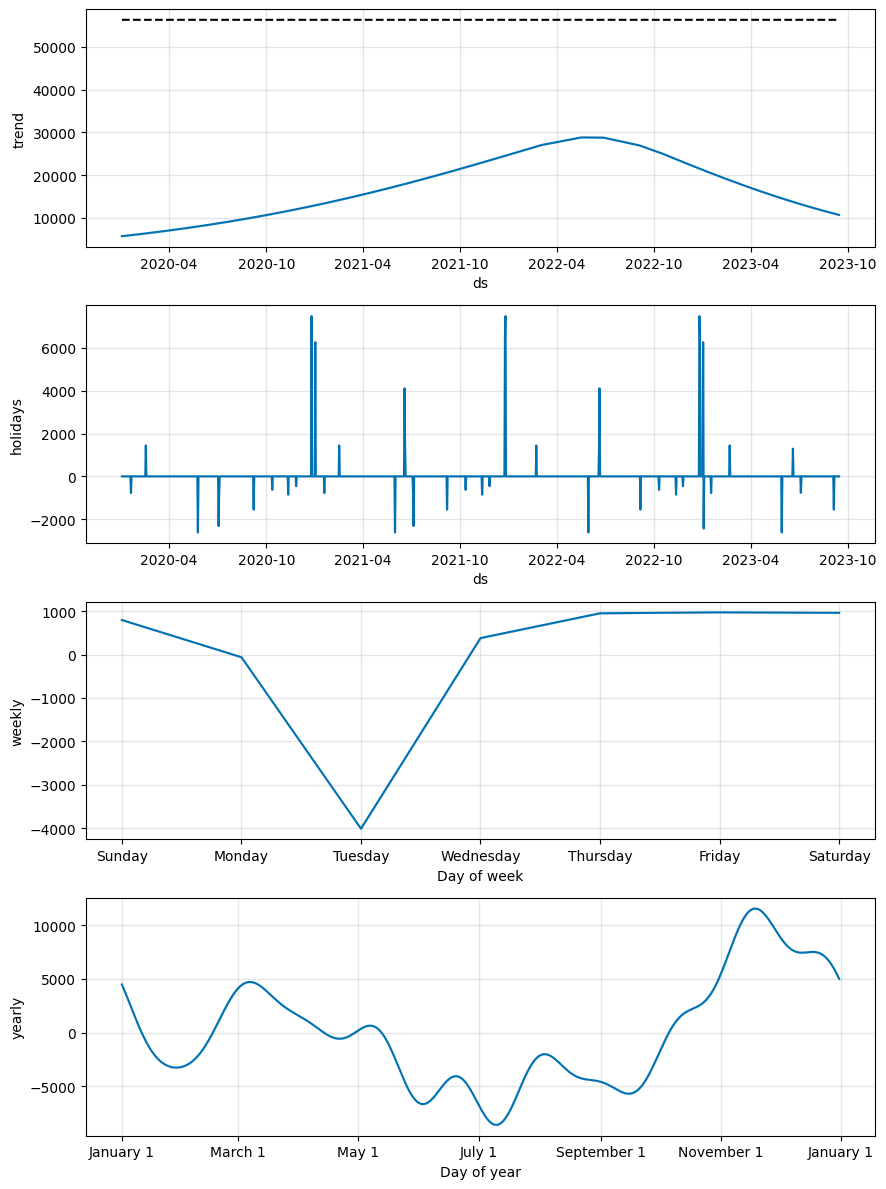

In [325]:
# holidays
m = Prophet(growth='logistic')
m.add_country_holidays(country_name='US')
m.fit(train)
# visualize holidays and seasonality
future = m.make_future_dataframe(periods=14)
future['cap'] = upper_bound
forecast = m.predict(future)
fig = m.plot_components(forecast)

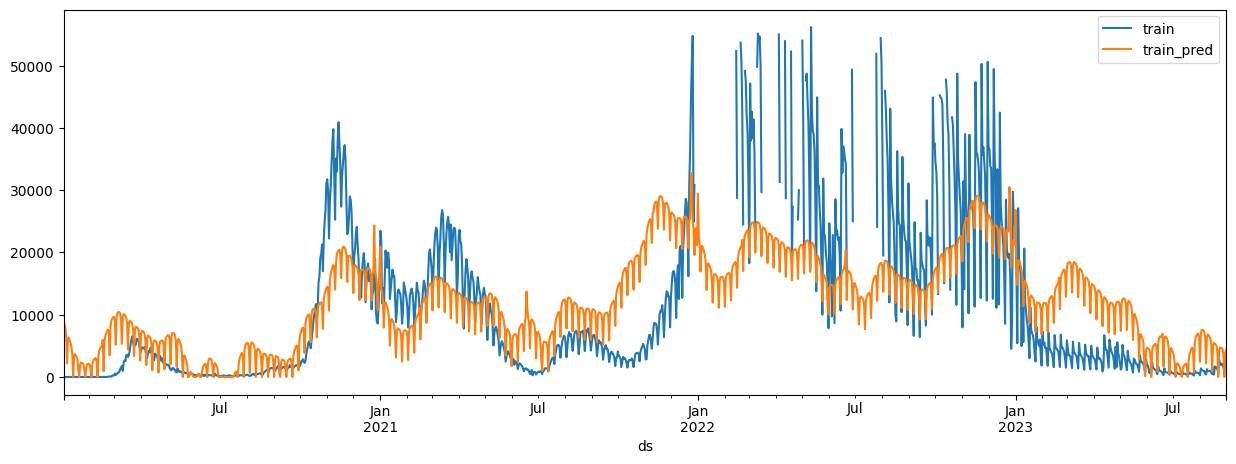

In [334]:
# base model with holiday
train_pred=m.predict(train).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

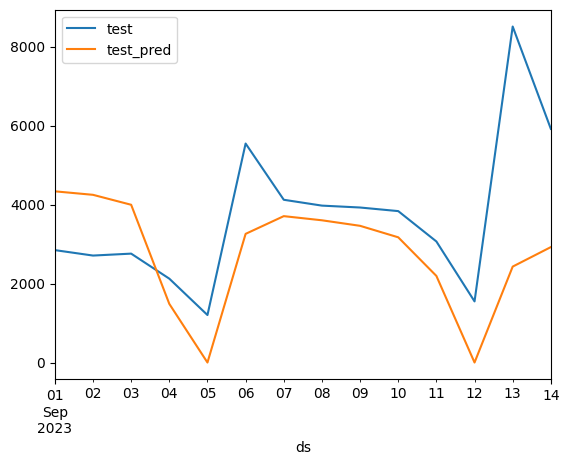

In [335]:
test_pred=m.predict(test).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [336]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 2125.7820221911247


### Model 2

In [329]:
# take into account holiday and incubation period
from prophet.make_holidays import make_holidays_df

us_holidays = make_holidays_df(
    year_list=[2020 + i for i in range(4)], country='US'
)
# italy had two lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-09', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-09', 'lower_window': 0, 'ds_upper': '2021-02-07'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
holidays = pd.concat((lockdowns, us_holidays))
holidays = holidays.reset_index()
holidays.loc[2:, 'ds_upper'] = holidays.loc[2:, 'ds'] + pd.Timedelta(days=7)
holidays.head()

,index,holiday,ds,lower_window,ds_upper,upper_window
0,0,lockdown_1,2020-03-09,0.0,2020-05-18,70.0
1,1,lockdown_2,2020-11-09,0.0,2021-02-07,90.0
2,0,Martin Luther King Jr. Day,2020-01-20,NaN,2020-01-27,NaN
3,1,Washington's Birthday,2020-02-17,NaN,2020-02-24,NaN
4,2,Columbus Day,2020-10-12,NaN,2020-10-19,NaN


In [374]:
m2 = Prophet(growth='logistic',
            holidays=holidays,
            # holidays_prior_scale = 25,
            # seasonality_prior_scale = 10,
            # changepoint_prior_scale = 0.1,
            # seasonality_mode = 'multiplicative'
             )
m2.fit(train)

22:01:28 - cmdstanpy - INFO - Chain [1] start processing
22:01:28 - cmdstanpy - INFO - Chain [1] done processing


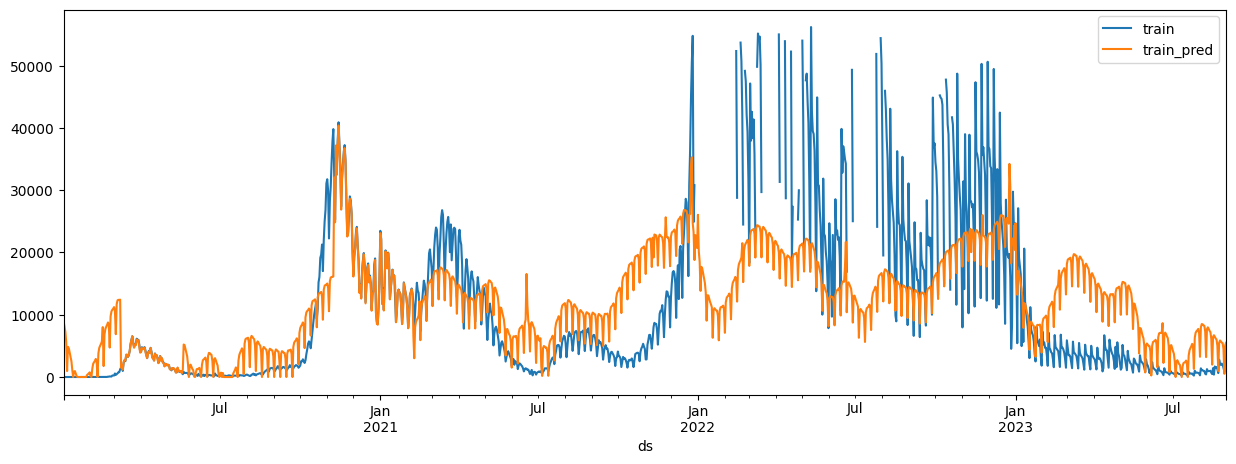

In [375]:
train_pred=m2.predict(train).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

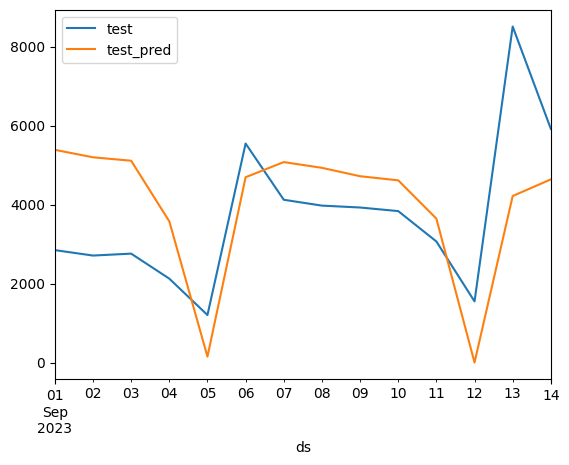

In [377]:
test_pred=m2.predict(test).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [378]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 1851.2113875619486


## Cross Validation
https://zerotomastery.io/blog/time-series-forecasting-with-facebook-prophet/#:~:text=Cross%2Dvalidation%20is%20an%20important,on%20the%20corresponding%20testing%20set.


In [294]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

#Store the results
rmse = []
#Loop
for params in grid:
  #model
  m = Prophet(growth='logistic',
              holidays = holidays,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.fit(train)

  #CV
  df_cv = cross_validation(m,
                          horizon = '14 days',
                          period = '100 days',
                          initial = '365 days',
                          parallel = 'processes')

  #Measure the error and store the result
  error = performance_metrics(df_cv)["rmse"].mean()
  rmse.append(error)

15:48:26 - cmdstanpy - INFO - Chain [1] start processing
15:48:26 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:28 - cmdstanpy - INFO

KeyboardInterrupt: 

In [ ]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params

,29
changepoint_prior_scale,0.005
holidays_prior_scale,25
seasonality_mode,multiplicative
seasonality_prior_scale,5
rmse,10256.346519


In [340]:
m3 = Prophet(growth='logistic',
             holidays=holidays,
             holidays_prior_scale = 25,
             seasonality_prior_scale = 5,
             changepoint_prior_scale = 0.005,
             seasonality_mode = 'multiplicative'
             )
m3.fit(train)

16:40:45 - cmdstanpy - INFO - Chain [1] start processing
16:40:45 - cmdstanpy - INFO - Chain [1] done processing


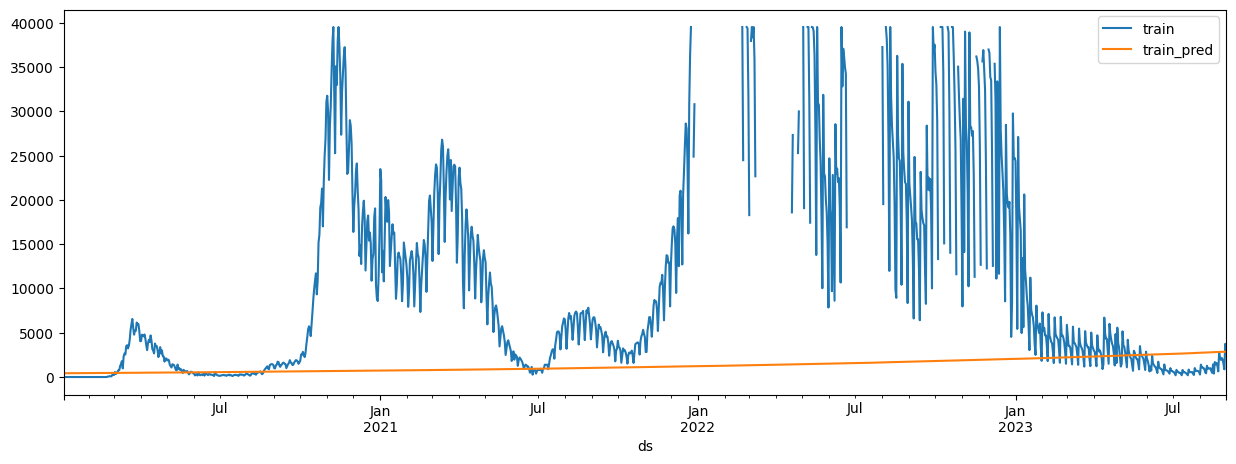

In [ ]:
train_pred=m3.predict(train).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

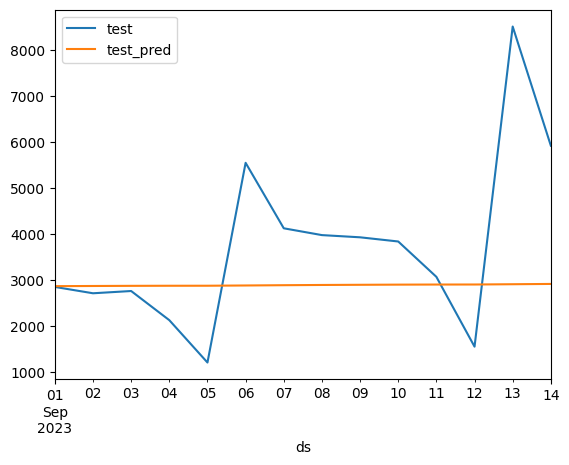

In [ ]:
test_pred=m3.predict(test).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [ ]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 1816.9250036904348
